In [1]:
# Import Python libaries
%matplotlib inline

# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# Machine learning & model visualization tools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc
import pydot
import math
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [2]:
dropped = ['Atmosphere', 'Mass', 'Init_R', 'Fin_R', 'Voltage', 'Res_Volt', 'PulseTime_I', 'I_Mean']
def import_file(filename):
    # Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'Charge_Tot', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    
    
    
    # Drop problematic data for this particular analysis
    dropped_features = ['Atmosphere', 'Res_Drop',
             'PulseTime_I', 'I_Mean', 'Maxima']
    df = df.drop(dropped_features, axis=1)
    
    
    
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    df = df.drop('Map File ID', axis = 1)
    df = df.drop('Tube Diam', axis = 1)
    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def import_file_noOneHot(filename):
# Convert to pandas dataframe & take a look
    # filename='FJH_ML.csv'
    df = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=1)
    # df = df.drop('Unnamed: 27', axis=1)
    # df = df.drop('Unnamed: 28', axis=1)
    # df = df.drop('Unnamed: 29', axis=1)
    df = df.dropna()
    # Convert numerical columns to float
    interest = ['Mass', 'Pretreat_voltage', 'Pretreat_highest', 'Voltage', 'PulseTime', 'Cap', 
                'Res_Volt', 'Init_R', 'Fin_R', 'Volt_Drop', 'Res_Drop', 'Yield_Per', 'I_Max', 
                'I_Mean', 'PulseTime_I', 'I_Final', 'Maxima', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D']
    for i in range(0, len(interest)):
        col = interest[i]
        df[col] = df[col].astype(float)
    # Fix percentages
    df['Graphene_Yield'] = df['Graphene_Yield']*100
    df['Yield_Per'] = df['Yield_Per']*100
    # Drop problematic data for this particular analysis
    # df = df[df['Yield_Per']>50]
    # Also drop asinine variables
    df = df.drop('Map File ID', axis = 1)
    df = df.drop('Tube Diam', axis = 1)
    # categorize_yield(df)
    # One-hot encode the data using pandas get_dummies
    # df = pd.get_dummies(df)
    # df = df[df['Material_CB']>0.5]
    # Drop 1 thing
    # df = df.drop['']
    # Dataset is now stored in a Pandas Dataframe
    # print(df.shape)
    # print(df.head())
    # print(df.isnull().sum())
    return df

def categorize_yield(df):
    yield_cat = []
    for i in range(0, len(df)):
        if df['Graphene_Yield'][i] < 50:
            yield_cat.append(0)
        elif df['Graphene_Yield'][i] < 50 and df['TwoDtoG'][i] < 0.8:
            yield_cat.append(1)
        else:
            yield_cat.append(2)
    print(len(df))
    print(len(yield_cat))
    df['Yield_Cat'] = yield_cat
    
def leave_one_out_proc(clf):
    # Leave one out evaluation
    # enumerate splits
    y_true, y_pred = list(), list()
    # Create leave one out procedure
    cv = LeaveOneOut()
    for train_ix, test_ix in cv.split(features):
        # split data
        train_features, test_features = features[train_ix, :], features[test_ix, :]
        train_labels, test_labels = labels[train_ix], labels[test_ix]
        clf.fit(train_features, train_labels)
        # evaluate model
        yhat = clf.predict(test_features)
        # store
        y_true.append(test_labels[0])
        y_pred.append(yhat[0])
    print('doneskies')
    return y_true, y_pred, clf

def category_normalization_theonesyoualwaysuse(df):
    groups = df.groupby(['Material'])
    norm_I_Max = []
    norm_charge_tot=[]
    for name, group in groups:
        I_Max_array = np.asfarray(group.I_Max)
        charge_tot_array = np.asfarray(group.Charge_Tot)
        mean_I_Max = np.mean(I_Max_array)
        mean_charge_tot = np.mean(charge_tot_array)
        std_I_Max = np.std(I_Max_array)
        std_charge_tot = np.std(charge_tot_array)
        print("Mean of ", name, "is ", mean_I_Max)
        norm_I_Max_cat = np.divide(np.subtract(I_Max_array, mean_I_Max), std_I_Max)
        norm_charge_tot_cat = np.divide(np.subtract(charge_tot_array, mean_charge_tot), std_charge_tot)
        norm_I_Max = np.append(norm_I_Max, norm_I_Max_cat)
        norm_charge_tot = np.append(norm_charge_tot, norm_charge_tot_cat)
    return norm_I_Max, norm_charge_tot

def category_normalization_mass(df):
    groups = df.groupby(['Material'])
    norm_array = []
    for name, group in groups:
        yield_array = np.asfarray(group.Mass)
        mean_yield = np.mean(yield_array)
        std_yield = np.std(yield_array)
        print("Mean of ", name, "is ", mean_yield)
        norm_yield_cat = np.divide(np.subtract(yield_array, mean_yield), std_yield)
        norm_array = np.append(norm_array, norm_yield_cat)
    return norm_array

In [3]:
# Import file
filename='FJH_ML_All_7_Edited.csv'
df1 = import_file_noOneHot(filename)
Imax, chargetot = category_normalization_theonesyoualwaysuse(df1)
yield_array = category_normalization_mass(df1)
df = import_file(filename)
# df['Norm_I_Max'] = Imax
df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
# df['Discharge_Rate'] = (df['Volt_Drop']/df['Mass'])/df['PulseTime']
# df['norm_mass'] = yield_array
# df['cap_energy'] = 0.5*df['Voltage']*df['Voltage']*df['Cap']/df['Mass']
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
# df['charge_density2'] = df['Volt_Drop']*df['Cap']/df['Mass']
# df['RC'] = df['Init_R']*df['Cap']
# df['test_feature'] = 1/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']
# df['discharge_per'] = df['Res_Volt']/df['Voltage']
# df['Pretreat_CD'] = df['Pretreat_highest']*df['Cap']/df['Mass']
# df['inv_Mass'] = 1/df['Mass']
# df['average_res'] = (df['Init_R']+df['Fin_R'])/2
# df['Power'] = df['I_Max']*df['I_Max']*df['average_res']/df['Mass']
# df = df.drop('average_res', axis=1)
# df['test_feature'] = df['Res_Volt']/df['Voltage']
# df = df.drop('norm_mass', axis=1)

# Drop stuff
df = df.drop('Voltage', axis=1)
df = df.drop('Res_Volt', axis=1)
# df = df.drop('Norm_I_Max', axis=1)
df = df.drop('Volt_Drop', axis=1)
df = df.drop('Mass', axis=1)
df = df.drop('Cap', axis=1)
df = df.drop('PulseTime', axis=1)
df = df.drop('I_Final', axis=1)
df = df.drop('Fin_R', axis=1)
df = df.drop('Init_R', axis=1)
df = df.drop('Pretreat_highest', axis=1)
df = df.drop('Pretreat_voltage', axis=1)
df = df.drop('Material_PA', axis=1)
df = df.drop('Material_TCB', axis=1)
# df = df.drop('Norm_charge_tot', axis=1)
df = df.drop('Charge_Tot', axis=1)
# df = df.drop('Final_Current_Percent', axis=1)
# df = df.drop('charge_density', axis=1)
# df = df.drop('average_res', axis=1)""
# df['FJH_Power'] = df['I_Max']*df['I_Max']*df['Init_R']
# df = df[df['Graphene_Yield']>20]

# Print stats
print(df.shape)
print(df.head())
# print(len(df))
print(sum(df['Material_MC']))

Mean of  CB is  199.5962952631579
Mean of  MC is  548.2808046511627
Mean of  PA is  301.9472116666666
Mean of  TCB is  217.5159437837838
Mean of  CB is  186.9859649122807
Mean of  MC is  276.5790697674419
Mean of  PA is  283.28055555555557
Mean of  TCB is  319.81081081081084
(173, 13)
   Yield  Yield_Per      I_Max  Graphene_Yield   TwoDtoG      DtoG    FWHM 2D  \
0   77.0  38.500000  149.36410       85.714286  0.798070  0.546842  52.940275   
1  147.2  90.920321   88.60687        1.010101  0.458187  0.912020   0.000000   
2  168.0  84.000000   88.60687       34.920635  0.650986  0.746614  40.452173   
3   54.0  27.000000  102.74530       79.365079  0.763019  0.661025  50.596165   
4  128.7  68.823529   70.26505       25.396825  0.646567  0.500579  40.277124   

   Material_CB  Material_MC  Norm_charge_tot  Norm_I_Max  charge_density  \
0            1            0        80.159727  746.820500      112.800000   
1            1            0        13.029621  547.293823       84.496603   

In [4]:
# Let's start the actual ML
# Labels are the values we want to predict
output = "Graphene_Yield"
if output != "Graphene_Yield":
    df = df[df['Graphene_Yield']>40]
labels = np.array(df[output])
labels = np.asfarray(labels)

# Remove the labels from the features
# axis 1 refers to the columns
# Drop all "output" type variables as well
outputs = ['Yield', 'Graphene_Yield', 'TwoDtoG', 'DtoG', 'FWHM 2D', 'Yield_Per', 'I_Max']
df = df.drop(outputs, axis=1)
# df = df.drop('Yield_Cat', axis=1)
# Saving feature names for later use
feature_list = list(df.columns)
# Convert to numpy array

features = np.array(df)
features = np.asfarray(features)
# features = preprocessing.scale(features)
# labels = preprocessing.scale(labels)

# Standardize model
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()
# features = scaler.fit_transform(features)
# Scale y values labels = scaler.fit_transform(labels.reshape(-1,1))
# print("Mean of y: ", np.mean(labels))
# print("Standard deviation of y: ", np.std(labels))
print("Mean of feature 1: ", features.mean(axis=0))
print("Standard deviation of feature 1: ", features.std(axis=0))

# Split the data into training and testing sets
rand = randint(1,50)
print(rand)
# Set Random seed if necessary
# Rand seed #8 was used to compile PD data as it performed particularly well
# Random seeds used to compile performance metrics for XGB-R were 8, 9, 22, 29, 42
rand=9
indices = np.arange(len(features))
train_features, test_features, train_labels, test_labels, idx1, idx2 = train_test_split(features, labels, indices, test_size = 0.2, random_state = rand)

Mean of feature 1:  [3.29479769e-01 2.48554913e-01 5.97953853e+01 1.26943987e+03
 9.24340497e+01 1.86378428e-01]
Standard deviation of feature 1:  [4.70024309e-01 4.32175159e-01 3.02708778e+01 7.23196082e+02
 3.40399052e+01 2.56602371e-01]
9


Pearsons correlation: -0.2881371337382632


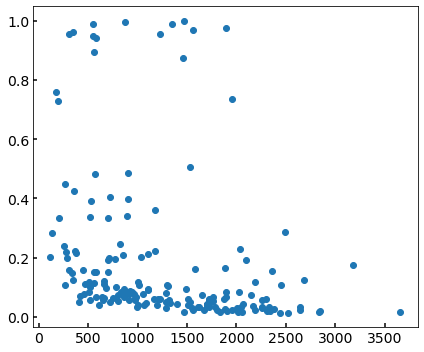

In [28]:
from scipy.stats import pearsonr
features1= features.transpose()
fig, ax = plt.subplots(figsize=(6,5))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
x = features1[3]
y = features1[5]

ax.scatter(x, y)
corr, _ = pearsonr(x, y)
print('Pearsons correlation:', corr)

# Save
plt.tight_layout()
plt.savefig('CorrMap35.png', dpi=300)
plt.show()

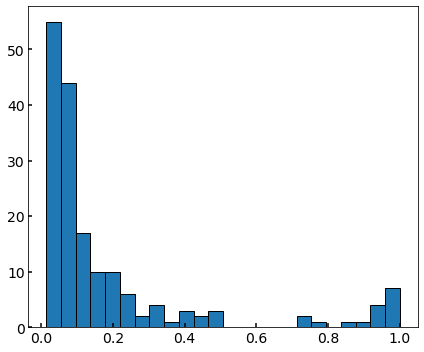

In [26]:
fig, ax = plt.subplots(figsize=(6,5))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
plt.hist(features1[5], edgecolor='black', bins=int(120/5))

# Save
plt.tight_layout()
plt.savefig('CorrMap55.png', dpi=300)
plt.show()

In [753]:
# Neural net
clf = MLPRegressor(hidden_layer_sizes=(100, 100, 100), activation='relu', 
                   alpha=0.05, learning_rate = 'adaptive', solver='adam')

# Train the model on training data
clf.fit(train_features, train_labels);

/Users/jacobbeckham/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
# Instantiate model with 1000 decision trees
clf = DecisionTreeRegressor(max_depth=4, min_samples_split=3)
# clf = XGBRegressor()
# Train the model on training data
clf.fit(train_features, train_labels);
print('doneskies')

doneskies


In [36]:
# Instantiate model with 1000 decision trees
clf = linear_model.BayesianRidge()
# clf = XGBRegressor()
# Train the model on training data
clf.fit(train_features, train_labels);
print('doneskies')

doneskies


In [727]:
# Instantiate model with 1000 decision trees
clf = linear_model.LinearRegression()
# clf = XGBRegressor()
# Train the model on training data
clf.fit(train_features, train_labels);
print('doneskies')

doneskies


In [5]:
# Instantiate model with 1000 decision trees
clf = XGBRegressor(max_depth=4, n_estimators=45, gamma=0.07, 
                   learning_rate = 0.118, subsample=0.725, min_child_weight = 2, 
                  random_state=100)
# clf = linear_model.BayesianRidge()
# clf = XGBRegressor()
# Train the model on training data
clf.fit(train_features, train_labels);
print('Doneskies')

Doneskies


In [31]:
# Instantiate model with 1000 decision trees
clf = RandomForestRegressor(max_depth=4, n_estimators=1000, min_samples_split=3)
# clf = linear_model.BayesianRidge()
# clf = XGBRegressor()
# Train the model on training data
clf.fit(train_features, train_labels);
print('doneskies')

doneskies


In [6]:
test_labels = np.asfarray(test_labels)

# Use the forest's predict method on the test data
predictions = clf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

Mean Absolute Error: 8.9353 units.


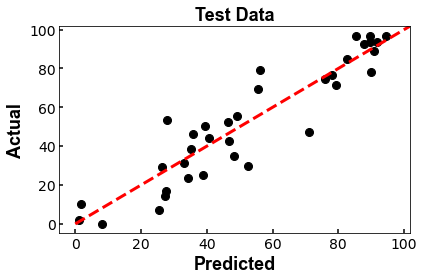

r2 score =  0.8600382205009847
RMSE =  11.32377447649295
MAE =  8.935264370397993


In [7]:
# Plot predictions vs actual values
# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(predictions, test_labels, linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TestData2DtoG_RF.png', dpi=300)
plt.show()

y_pred = predictions
y_true = test_labels

r_squared = r2_score(test_labels, predictions)
print('r2 score = ', r_squared)
rmse = math.sqrt(mean_squared_error(test_labels, predictions))
print('RMSE = ', rmse)
mae = mean_absolute_error(test_labels, predictions)
print('MAE = ', mae)
# corr, _ = pearsonr(test_labels, predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(predictions, test_labels)
# print('Accuracy: %.3f' % acc)

#### Performance on test data
train_predictions = clf.predict(train_features)

# Plot style
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
# ax.set_xlim(20,105)
# ax.set_ylim(20,105)

# Predicted 2D/G
plt.plot(train_predictions, train_labels, linestyle = 'none', marker = 'o', color='black', markersize='8')
plt.title('Training Data', fontsize='18', fontname='Arial', fontweight='bold')
plt.xlabel('Predicted', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Actual', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(0, ymax*1.1, .1)
y2 = np.arange(0, ymax*1.1, .1)
plt.plot(x2,y2, linestyle='--', linewidth = '3', color='red')

# Save
plt.tight_layout()
# plt.savefig('TrainingData2DtoG_RF.png', dpi=300)
plt.show()

r_squared = r2_score(train_labels, train_predictions)
print('r2 score = ', r_squared)
mae = mean_absolute_error(train_labels, train_predictions)
print('MAE = ', mae)
# corr, _ = pearsonr(train_labels, train_predictions)
# print('Pearsons correlation: %.3f' % corr)
# acc = accuracy_func(train_predictions, train_labels)
# print('Accuracy: %.3f' % acc)

In [561]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator=XGBRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (45,50,51,52),
            'min_child_weight': range(2,5),
            'learning_rate': np.linspace(0.07, 0.13, 6),
            'subsample': np.linspace(0.7, 0.8, 5),
            'gamma': np.linspace(0.07, 0.13, 6)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('Max Depth: ', best_params["max_depth"])
print('N Estimators: ', best_params["n_estimators"])
print('Min Child Weight: ', best_params["min_child_weight"])
print('Learning Rate: ', best_params["learning_rate"])
print('Subsample: ', best_params["subsample"])
print('Gamma: ', best_params["gamma"])

Max Depth:  4
N Estimators:  51
Min Child Weight:  2
Learning Rate:  0.11800000000000001
Subsample:  0.725
Gamma:  0.07


In [22]:
# Random forest
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'min_samples_split': range(2,5),
            'n_estimators': (200, 500, 1000)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('Max Depth: ', best_params["max_depth"])
print('Min samples split: ', best_params["min_samples_split"])
print('N Estimators: ', best_params["n_estimators"])

KeyboardInterrupt: 

In [329]:
# Decision tree
gsc = GridSearchCV(
        estimator=DecisionTreeRegressor(),
        param_grid={
            'max_depth': range(3,7), 
            'min_samples_split': range(2,4)
            # 'learning_rate': (0.0001, 0.001, 0.01, 0.1, 0.2), 
            # 'n_estimators': (100, 200, 300, 400, 500)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('Max depth: ', best_params["max_depth"])
print('Min samples split: ', best_params["min_samples_split"])

Max depth:  4
Min samples split:  3


In [152]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: charge_density       Importance: 0.3400000035762787
Variable: Material_CB          Importance: 0.18000000715255737
Variable: Material_MC          Importance: 0.17000000178813934
Variable: Norm_charge_tot      Importance: 0.14000000059604645
Variable: Norm_I_Max           Importance: 0.10000000149011612
Variable: Final_Current_Percent Importance: 0.07000000029802322


Mean of  CB is  199.5962952631579
Mean of  MC is  548.2808046511627
Mean of  PA is  301.9472116666666
Mean of  TCB is  217.5159437837838


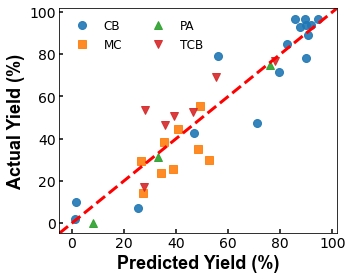

In [21]:
# Plot style
fig, ax = plt.subplots(figsize=(5,4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Import file
filename='FJH_ML_All_7_Edited.csv'
df = import_file_noOneHot(filename)
# Create normalized I by category
norm1, norm2 = category_normalization_theonesyoualwaysuse(df)
df['Norm_I_Max'] = norm1
df['Norm_charge_tot'] = norm2
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
# df['test_feature'] = (df['Voltage']/df['Mass'])#*df['PulseTime']
# df = df[df['TwoDtoG']<1.5]
# df = df[df['Graphene_Yield']>20]

# Cut dataframe to only the test set
df = df.iloc[idx2]
df['y_pred'] = y_pred
df['y_true'] = y_true

groups = df.groupby(['Material'])

# Plot
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
counter=0
markers = ['o', 's', '^', 'v']
colors=['blue', 'red', 'green', 'orange']
colors2 = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
for name, group in groups:
    ax.plot(group.y_pred, group.y_true, marker=markers[counter], alpha=0.9, linestyle='', ms=8, label=name)
    counter+=1
    # Predicted 2D/G
# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
leg = plt.legend(frameon="True", prop={'family': 'Arial'})
ax.legend(frameon=False, ncol=2, fontsize=12, loc='upper left')

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
plt.savefig('XGBPerformanceJune25.png', dpi=300)
plt.show()

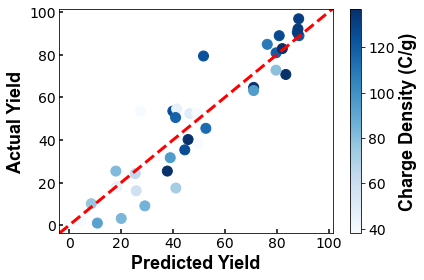

In [606]:
# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='14')
for name, group in groups:
    p = ax.scatter(group.y_pred, group.y_true, c=group.charge_density, marker='o', s=100, cmap='Blues')
    
cb = fig.colorbar(p, ax=ax)
cb.set_label('Charge Density (C/g)', fontsize='18', fontname='Arial', fontweight='bold')
cb.ax.tick_params(labelsize=14)

# plt.title('Test Data', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_xlabel('Predicted Yield', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('Actual Yield', fontsize='18', fontname='Arial', fontweight='bold')
ymin, ymax = plt.ylim()
ax.set_xlim(ymin, ymax)
ax.set_ylim(ymin, ymax)
# Make a red line to show perfect predictions
x2 = np.arange(ymin, ymax*1.1, .01)
y2 = np.arange(ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '3', color='red')
# ax.legend(fontsize=12)

# Plot
# plt.plot(df['I_Max'],df['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')

# Save
plt.tight_layout()
# plt.savefig('XGB_Regression_Performance_colorChargeDensity.png', dpi=300)
plt.show()

In [72]:
# Train neural network
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(
        estimator=MLPRegressor(),
        param_grid={'hidden_layer_sizes': [(100, 100, 100), (10,10,10), (50,50,50), (200, 200, 200)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.05, 0.10, 0.12, 0.15],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam'],
          'n_iter_no_change': range(3,7)
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
grid_result = gsc.fit(train_features, train_labels)
best_params = grid_result.best_params_
print('hidden layer: ', best_params["hidden_layer_sizes"])
print('activation: ', best_params["activation"])
print('learning_rate: ', best_params["learning_rate"])
print('solver ', best_params["solver"])
print('alpha ', best_params["alpha"])
print('N_iter_no_change ', best_params["n_iter_no_change"])

hidden layer:  (100, 100, 100)
activation:  relu
learning_rate:  adaptive
solver  adam
alpha  0.05


In [ ]:
#M2 Multilayer Perceptron
model = 'M2 MLP'
print(model)
def build_mlp(units = 20, optimizer = 'rmsprop'):
    mlp = Sequential()
    mlp.add(Dense(units = units, activation = 'relu', input_dim = features.shape[1]))
    mlp.add(Dense(units = units, activation = 'relu', ))
    mlp.add(Dense(units = 1))
    mlp.compile(optimizer = optimizer, 
                loss='mean_squared_error', 
                metrics = ['mae'])
    return mlp
mlp = KerasRegressor(build_fn = build_mlp, verbose = 0)
grid_param_mlp = {'units': [20, 40, 60],
                    'batch_size': [16, 32, 64, 128],
                    'epochs': [100, 500, 1000],
                    'optimizer': ['rmsprop', 'adam']}
grid_mlp = GridSearchCV(mlp, grid_param_mlp) 
grid_mlp.fit(train_features, train_labels)
y_pred_train_mlp = grid_mlp.predict(train_features)
y_pred_test_mlp = grid_mlp.predict(test_features)
df_eval_mlp = save_evaluate_draw(y_pred_train_mlp, y_pred_test_mlp, 
                                grid_param_mlp, grid_mlp.best_params_, 
                                grid_mlp.best_estimator_, model)

print('Doneskies')


In [8]:
feature_names = ['CB SM', 'MC SM', 'A$\mathregular{_{IT}}$', 'I$\mathregular{_{Max}}$', 'CD', 'I$\mathregular{_{f}}$/I$\mathregular{_{Max}}$']
pdp = partial_dependence(clf, features, (5,4))
print('Done!')

Done!


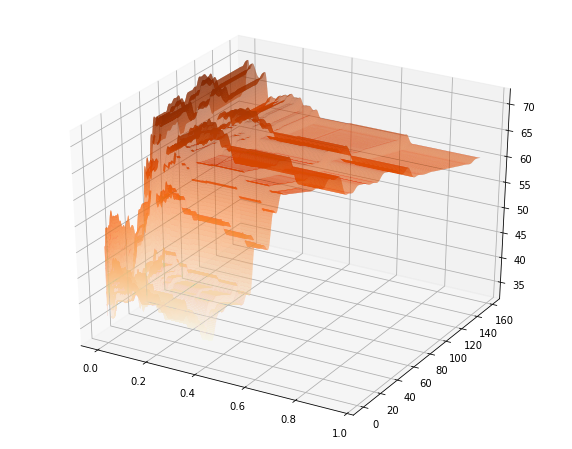

In [9]:
# 3,4 then 2,4 then 2,3 then 5,4
# 4 is CD, 3 is Imax, 2 is AIT, 5 is If/Imax

X=pdp[1][0]
Y=pdp[1][1]
Z=pdp[0][0]
X, Y = np.mgrid[0:X:100j, 0:Y:100j]

resultX = ndimage.zoom(X, 10.0)
resultY = ndimage.zoom(Y, 10.0)
resultZ = ndimage.zoom(Z, 10.0)

fig, ax2 = plt.subplots(figsize=(10,8))
ax2 = plt.axes(projection='3d')
ax2.plot_surface(resultX, resultY, resultZ, rstride=1, cstride=1, cmap='Oranges', alpha=0.7, shade=False, antialiased=True)
plt.show()

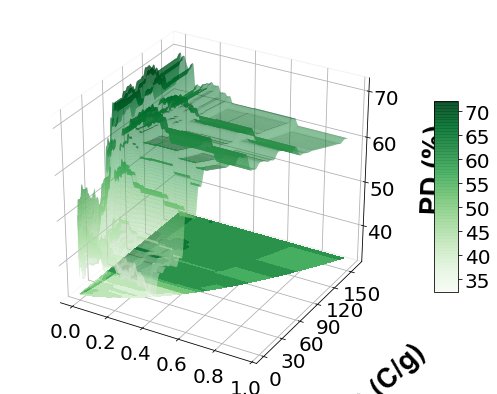

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0, labelsize=16)

# Now set color to white (or whatever is "invisible")
# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')
# Bonus: To get rid of the grid as well:
# ax.grid(False)
ax.tick_params(direction='in', length=4, width=1.5, grid_alpha=0, labelsize=20)

cset = ax.contourf(resultX, resultY, resultZ, zdir='z', offset=np.min(Z), cmap='Greens')
# cset = ax.contourf(X, Y, Z, zdir='x', offset=0, cmap='Oranges')
# cset = ax.contourf(X, Y, Z, zdir='y', offset=165, cmap='Oranges')
# print(Z)

surf = ax.plot_surface(resultX, resultY, resultZ, rstride=1, cstride=1, cmap='Greens', alpha=0.7, shade=False, antialiased=True)
cb = fig.colorbar(surf, shrink=0.5, aspect=8)
for t in cb.ax.get_yticklabels():
     t.set_fontsize(20)

ax.set_xlabel('\n\nI$\mathregular{_{F}}$/I$\mathregular{_{Max}}$ (a.u.)', fontfamily='Arial', fontweight='bold', fontsize=28, linespacing=3)
# ax.set_xlabel('\nA$\mathregular{_{IT}}$ (C/g)', fontfamily='Arial', fontweight='bold', fontsize=28)
# ax.set_xlabel('\nI$\mathregular{_{Max}}$ (A/g)', fontfamily='Arial', fontweight='bold', fontsize=28)
ax.set_ylabel('\n\nCD (C/g)', fontfamily='Arial', fontweight='bold', fontsize=28, linespacing=3)
ax.set_zlabel('\nPD (%)', fontfamily='Arial', fontweight='bold', fontsize=28, linespacing=3)
# ax.view_init(30, -150)

ax.set_yticks([0, 30, 60, 90, 120, 150])

plt.savefig('3Dplot4_IfImax_CD_PD.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
print(len(errors))

print(errors)

35
[18.25081657 13.76209549 13.5034717  10.79683797  3.87229028  8.11953926
  7.22987678 13.43366471  7.73462579 10.41525408  2.19850471  6.3015845
 13.18981416  3.84370206 23.6424088  11.65191638 22.69132614  1.19792172
  0.77435358 11.29548194  3.03049444  5.11097286  3.91347172  1.87427333
  2.93880714  8.44188608  1.88391536  2.15219574 10.47670819  1.76158014
  1.32239583  5.9202644  25.5615914  11.14815124 23.29205846]


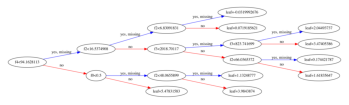

In [11]:
# plot single tree
plot_tree(clf, num_trees=5, rankdir='LR')
plt.savefig('XGBtree.png', dpi=300)
plt.show()

In [34]:

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree2.dot', feature_names = feature_list, rounded = True, precision = 1)

In [35]:
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree2.dot')
# Write graph to a png file
graph.write_png('sampleTree.png')

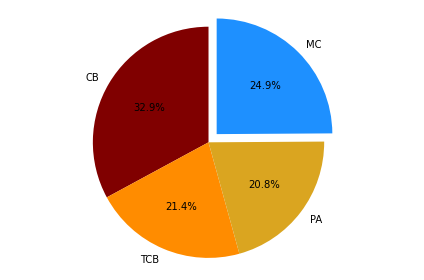

In [87]:
import matplotlib.pyplot as plt

x = 100
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
features2 = ['CB', 'TCB', 
             'PA', 'MC']
importances2 = [32.9/x, 21.4/x, 20.8/x, 24.9/x]
colors = ['maroon', 'darkorange', 'goldenrod', 'dodgerblue']
explode = (0, 0.0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='16')
ax1.pie(importances2, explode=explode, labels=features2, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Format and save
plt.tight_layout()
plt.savefig('Materialmetrics.png', dpi=300) # Change file name